# LoopGAN — Loop generation with StyleGAN2 and MelGAN

In [1]:
import argparse
import torch
from torchvision import utils
from model_drum import Generator
import sys
sys.path.append('./melgan')
from modules import Generator_melgan
import os, random
import librosa, librosa.display
import soundfile as sf
import numpy as np
from utils import *
import matplotlib.pyplot as plt
import IPython.display as ipd

### Download a pre-trained model in advance

``` 
$ gdown -O drumbeats1_230000.pt 1VL7kfHGMTcpniZllKZtNnN1inT9AsNzu
```

In [2]:
import os

# Use the Windows temporary directory
temp_dir = os.getenv('TEMP')

# Saving the generated spectrogram image
randid = random.randint(0, 10000)
imagepath = os.path.join(temp_dir, f'img_{randid}.png')
filepath = os.path.join(temp_dir, f'gem_{randid}.wav')

# Ensure the paths are correct
print(f"Image path: {imagepath}, Audio path: {filepath}")

Image path: C:\Users\anecoica\AppData\Local\Temp\img_2393.png, Audio path: C:\Users\anecoica\AppData\Local\Temp\gem_2393.wav


In [3]:

# Constants - do not change! 
N_LATENT = 512
N_MLP = 8
SIZE_OUTPUT = 64 # size of output image
TRUNCATION = 1 # if this is >=1, then no truncation
VARIATION  = 0.1
TRUNCATION_MEAN = 4096 # # of samples for getting mean latent
SR = 44100

# Number of samples (loops) in a batch
n_samples = 4  # batch size

# name of pre-trained StyleGAN2 model
CHECKPOINT = "./drumbeats1_230000.pt" 

# mean / std of Spectrograms of training data. used for the conversion from generated spectrograms into wav files
DATAPATH = "./data/drumbeats_1bar/" 

# name of pre-trained MelGAN model
MELGAN_MODEL_NAME = "best_netG.pt"

# GANSpace - # of PCA components
N_PCA_COMPS = 6

# Use "cuda" if you have GPUs on your machine
device_name = "cpu" # "cuda"


### Load models

In [4]:
# Load a StyleGAN2 model
generator = Generator(SIZE_OUTPUT, N_LATENT, N_MLP, channel_multiplier=2).to(device_name)
checkpoint = torch.load(CHECKPOINT, map_location=torch.device(device_name))

generator.load_state_dict(checkpoint["g_ema"], strict=False)

# Global reference for the generator
g_ema = generator
mean_latent = None  # Initially set it to None

if TRUNCATION < 1:
    with torch.no_grad():
        mean_latent = generator.mean_latent(TRUNCATION_MEAN)
else:
    mean_latent = None

C:\Users\anecoica\AppData\Local\Temp\ipykernel_17992\3260780433.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(CHECKPOINT, map_location=torch.de

In [5]:
# Load a MelGAN model
def load_vocoder(device_name):
    feat_dim = 80
    mean_fp = f'{DATAPATH}/mean.mel.npy'
    std_fp = f'{DATAPATH}/std.mel.npy'
    v_mean = torch.from_numpy(np.load(mean_fp)).float().view(1, feat_dim, 1).to(device_name)
    v_std = torch.from_numpy(np.load(std_fp)).float().view(1, feat_dim, 1).to(device_name)
    
    vocoder_config_fp = './melgan/args.yml'
    vocoder_config = read_yaml(vocoder_config_fp)

    n_mel_channels = vocoder_config.n_mel_channels
    ngf = vocoder_config.ngf
    n_residual_layers = vocoder_config.n_residual_layers

    vocoder = Generator_melgan(n_mel_channels, ngf, n_residual_layers).to(device_name)
    vocoder.eval()

    vocoder_param_fp = os.path.join('./melgan', MELGAN_MODEL_NAME)
    vocoder.load_state_dict(torch.load(vocoder_param_fp, map_location=torch.device(device_name)), strict=False)

    return vocoder, v_mean, v_std

VOCODER, V_MEAN, V_STD = load_vocoder(device_name)

def vocode(sample, vocoder=VOCODER, v_mean=V_MEAN, v_std=V_STD):
    de_norm = sample.squeeze(0) * v_std + v_mean
    audio_output = vocoder(de_norm)
    return audio_output

c:\Users\anecoica\miniconda3\envs\loopgan\lib\site-packages\torch\nn\utils\weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
C:\Users\anecoica\AppData\Local\Temp\ipykernel_17992\4169813888.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend y

# GANSpace 

PCA on randomly generated W vectors to get meaningful style vector directions.

Härkönen, Erik, Aaron Hertzmann, Jaakko Lehtinen, and Sylvain Paris. 2020. “GANSpace: Discovering Interpretable GAN Controls.” arXiv [cs.CV]. arXiv. http://arxiv.org/abs/2004.02546.


Explained Variance:  [0.13354716 0.09284852 0.07877245 0.03337357 0.02214479 0.02137296]


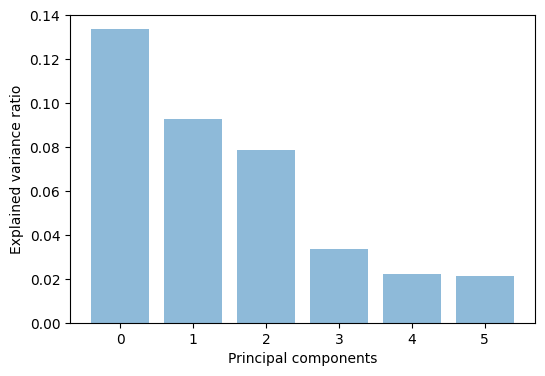

How many PCA components we need?


In [6]:
from sklearn.decomposition import PCA

# Generate random W (style vectors) with random Z 
randz = torch.randn(2000, N_LATENT, device=device_name) 
randw = generator.get_latent(randz).detach().cpu().numpy()

# Find principal components using PCA 
pca = PCA(n_components=N_PCA_COMPS)
pca.fit(randw)
pcomponents = torch.tensor(pca.components_) # PCA components

# Explained variance
explained_variance = pca.explained_variance_ratio_
print('Explained Variance: ', explained_variance)

# Scree plot
plt.figure(figsize=(6, 4))
plt.bar(range(len(explained_variance)), explained_variance, alpha=0.5, align='center')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.show()
print("How many PCA components we need?")

# probably 6 components are enough

### Generation

To make it easier to handle on Max/MSP, generated loops is saved as a wav file with `n_samples` channels. (default: 4ch)

In [7]:
from pydub import AudioSegment
import os
prev_w = None

# Adde PCAed W vector
def get_w(w, coefs, scale=1.0):
    coefs = coefs[:N_PCA_COMPS]
    w_diff = pcomponents * torch.tensor([coefs]).T
    w_diff = w_diff.to(device_name)
 
    # add each PCA component vector
    for i in range(w.shape[0]): # batch
        for j in range(w_diff.shape[0]):
            w[i] += w_diff[j]       
    return w

# main function
# g_ema: stylegan generator
# center_z: to specify the input latent z 
# trucation: GAN trucation value
# variation: the scale of noise added to center_z (= vatiation in a batch)
def generate(g_ema=generator, 
             center_z=None, 
             use_prev_w = False, 
             truncation=TRUNCATION, 
             variation=VARIATION, 
             coef=None):
    global prev_w

    print("generating...")

    with torch.no_grad():
        g_ema.eval()
        
        if not use_prev_w or prev_w == None:
            if center_z is None:
                # random init
                sample_z = torch.randn(1, N_LATENT, device=device_name)
                sample_z = sample_z.repeat(n_samples, 1) +  torch.randn(n_samples, N_LATENT, device=device_name) * variation
            else:
                # use specific latent z
                sample_z = center_z + torch.randn(n_samples, N_LATENT, device=device_name) * variation
            sample_z = sample_z.float()
            
            # Generate!!!            
            sample_w = g_ema.get_latent(sample_z)
        else:
            sample_w = prev_w

        # store for the next round
        prev_w = sample_w.detach().clone()

        if coef and use_prev_w:
            sample_w = get_w(sample_w, coef)
        
        # Apply truncation only if mean_latent is available and truncation is less than 1
        if truncation < 1 and mean_latent is not None:
            latent = truncation * (sample_w - mean_latent) + mean_latent
        else:
            latent = sample_w
                    
        sample_w = sample_w.unsqueeze(1).repeat(1, N_LATENT, 1)    
        sample, _ = g_ema([sample_w], truncation=truncation, truncation_latent=mean_latent, input_is_latent=True)

        # Saving tje generated spectrogram image
        randid = random.randint(0, 10000)
        
        temp_dir = os.getenv('TEMP')

        imagepath = os.path.join(temp_dir, f'img_{randid}.png')
        # Saving the generated spectrogram image
        utils.save_image(sample, imagepath, nrow=1, normalize=True, value_range=(-1, 1))


        # sample_spec = (sample * V_STD + V_MEAN).squeeze().detach().cpu().numpy()
        # librosa.display.specshow(sample_spec[0], sr=44100, hop_length=257, n_fft=1024)

        # Saving multi channel audio file
        filepath = os.path.join(temp_dir, f'gem_{randid}.wav')
        channels = [] 
        numpy_chs = []  # for numpy array
        # convert (n_samples) spectrogram into audio, one by one 
        for i in range(n_samples):
            audio_output = vocode(sample[i])
            audio_output = audio_output.squeeze().detach().cpu().numpy() 
            numpy_chs.append(audio_output)
  
            channel = AudioSegment( (audio_output*np.iinfo(np.int16).max).astype("int16").tobytes(), sample_width=2, # 16 bit 
                    frame_rate=SR, channels=1)
            channels.append(channel)
        # save as a wav file with (n_samples) channel
        multich = AudioSegment.from_mono_audiosegments(*channels)
        multich.export(filepath, format="wav")
        
        return filepath, imagepath, np.array(numpy_chs)


### Test

Let's generate random loops with random input latent z

generating...


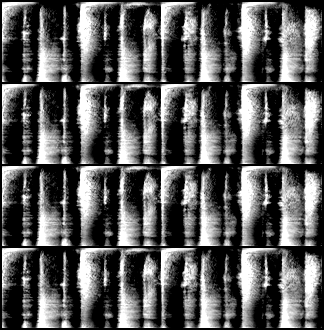

In [8]:
# random generation 
_,  imagepath, audio_output = generate(variation=0.0)

# display the generated spectrogram
ipd.display(ipd.Image(filename=imagepath))


# play the first channel
ipd.display(ipd.Audio(audio_output[0], rate=SR))

# GANSpace Inrterpolation
interpolation of the first PCA components

In [9]:
# baseline
print("baseline rhythm")
_,  imagepath, audio_output = generate(variation=0.0)
ipd.display(ipd.Audio(audio_output[0], rate=SR))
print("------------")
print("\n")

# changing the 1st component
print("changing the 1st PCA component")
#for x in np.linspace(-10, 10, 7):
#    _, _, audio_output  = generate(center_z=None, use_prev_w=True, coef = [x,0,0,0,0,0]) 
#    print("1st component:", x)
#    ipd.display(ipd.Audio(audio_output[0], rate=SR))

baseline rhythm
generating...


------------


changing the 1st PCA component


#### Stereo effect
Small gausian noise can be added to the input latent vector z. If you play the first and second sample in the generated batch as a stereo audio file, then you'll get an interesting stereo effect. Try different numbers! 

generating...


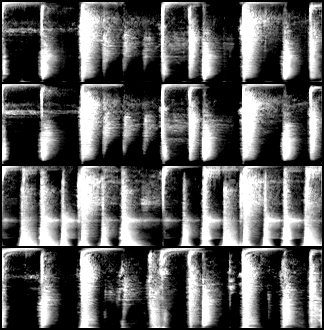

In [10]:
_,  imagepath, audio_output = generate(variation=0.35)

ipd.display(ipd.Audio(audio_output[:2], rate=SR)) # stereo 

ipd.display(ipd.Image(filename=imagepath))


### OSC server/client for Max/MSP

In [11]:
# test
audiopath, imagepath, _ = generate(center_z=None, use_prev_w=False, truncation=1.0, variation=0.1, coef=[0, 0, 0, 0, 0, 0])
print(f"Audio path: {audiopath}, Image path: {imagepath}")


generating...
Audio path: C:\Users\anecoica\AppData\Local\Temp\gem_81.wav, Image path: C:\Users\anecoica\AppData\Local\Temp\img_81.png


In [12]:
from pythonosc import dispatcher
from pythonosc import osc_server, udp_client
import os, random

# client
client = udp_client.SimpleUDPClient('127.0.0.1', 10018)
variation = 0.10
truncation = 1.0
coef = [0, 0, 0, 0, 0, 0]  # Default PCA coefficients

# OSC handler to update variation
def set_variation(unused_addr, variation_value):
    global variation
    variation = variation_value
    print(f"Variation set to: {variation}")

# OSC handler to update truncation
def set_truncation(unused_addr, truncation_value):
    global truncation
    truncation = truncation_value
    print(f"Truncation set to: {truncation}")

# OSC handler to update PCA coefficients
def set_coefficients(unused_addr, *coefficients):
    global coef
    coef = list(coefficients)[:6]  # Ensure only 6 values
    print(f"PCA coefficients set to: {coef}")
# generate randomly
def generate_random(unused_addr, x1,x2,x3,x4,x5,x6, variation, truncation):
    global mean_latent, g_ema
    print(f"Received: x1={x1}, x2={x2}, ..., variation={variation}, truncation={truncation}")
    # Initialize mean_latent for truncation if needed
    if truncation < 1 and mean_latent is None:
        mean_latent = g_ema.mean_latent(TRUNCATION_MEAN)

    print("Generating random sample...")    
    audiopath, imagepath, _ = generate(center_z=None, 
                                       use_prev_w=True, 
                                       truncation=truncation,
                                       variation=variation, 
                                       coef = [x1,x2,x3,x4,x5,x6]) # random sample
    print(f"Generated audio: {audiopath}, image: {imagepath}")

    client.send_message("/generated", (audiopath, imagepath)) # init both R and L
    print("Message sent to Max")


# morphing
def generate_xy(unused_addr, x1,x2,x3,x4,x5,x6, variation, truncation):
    global mean_latent, g_ema
    print(f"Received: x1={x1}, x2={x2}, ..., variation={variation}, truncation={truncation}")
    # Initialize mean_latent for truncation if needed
    if truncation < 1 and mean_latent is None:
        mean_latent = g_ema.mean_latent(TRUNCATION_MEAN)
    print("Generating random sample...")     
    audiopath, imagepath, _  = generate(center_z=None, 
                                        use_prev_w=True,
                                        truncation=truncation,
                                        variation=variation, 
                                        coef = [x1,x2,x3,x4,x5,x6]) # random sample
    print(f"Generated audio: {audiopath}, image: {imagepath}")
    client.send_message("/generated", (audiopath, imagepath))
    print("Message sent to Max")
# server
dispatcher = dispatcher.Dispatcher()
dispatcher.map("/set_variation", set_variation)
dispatcher.map("/set_truncation", set_truncation)
dispatcher.map("/set_coefficients", set_coefficients)
dispatcher.map("/generate_random", generate_random)
dispatcher.map("/generate_xy", generate_xy)

server = osc_server.ThreadingOSCUDPServer(
    ('localhost', 10015), dispatcher)
print("Serving on {}".format(server.server_address))
try:
    print("Serving on {}".format(server.server_address))
    while True:
        server.handle_request()  # Handle one request at a time
except KeyboardInterrupt:
    print("Server stopped.")




Serving on ('127.0.0.1', 10015)
Serving on ('127.0.0.1', 10015)
Received: x1=0.0, x2=0.0, ..., variation=0.30000001192092896, truncation=0.5400000214576721
Generating random sample...
generating...
Generated audio: C:\Users\anecoica\AppData\Local\Temp\gem_8591.wav, image: C:\Users\anecoica\AppData\Local\Temp\img_8591.png
Message sent to Max
Received: x1=0.0, x2=0.0, ..., variation=0.30000001192092896, truncation=0.10000000149011612
Generating random sample...
generating...
Generated audio: C:\Users\anecoica\AppData\Local\Temp\gem_3280.wav, image: C:\Users\anecoica\AppData\Local\Temp\img_3280.png
Message sent to Max
Received: x1=0.0, x2=0.0, ..., variation=0.30000001192092896, truncation=0.20000000298023224
Generating random sample...
generating...
Generated audio: C:\Users\anecoica\AppData\Local\Temp\gem_4910.wav, image: C:\Users\anecoica\AppData\Local\Temp\img_4910.png
Message sent to Max
Received: x1=0.0, x2=0.0, ..., variation=0.30000001192092896, truncation=0.30000001192092896
Gene